In [42]:
import time
import tabulate
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

import sys 
sys.path.append("/Users/larry/Documents/GitHubProjects/inventory") 

from inventory.gsm_tree import *
from inventory.gsm_tree_helpers import *
from inventory.ssm_serial import *

## Finding Optimal k

Some functions to solve the GSM system for a particular value of k, and
to optimize over k.

In [72]:
# Function that takes k as parameter and does the optimization.
# Returns:
# - optimal base-stock levels
# - GSM cost 
# - SSM cost 
def opt_wrt_k(k, tree):
    for n in tree.nodes:
        tree.nodes[n]['demand_bound_constant'] = k
    tree = preprocess_tree(tree)
    GSM_cost, opt_cst = optimize_committed_service_times(tree)
    opt_bsl = cst_to_base_stock_levels(tree, tree.nodes, opt_cst)
    
    # Convert tree to SSM.
    SSM_tree = GSM_to_SSM(tree)

    # Calculate SSM cost.
    GSM_echelon_bsl = local_to_echelon_base_stock_levels(SSM_tree, opt_bsl)
    SSM_cost = expected_cost(SSM_tree, GSM_echelon_bsl, x_num=500, d_num=100)

#    print("k={}: BSL={} GSM_echelon_bsl={} SSM_cost={}".format(k, opt_bsl[1], GSM_echelon_bsl[1], SSM_cost))
    return opt_bsl, GSM_cost, SSM_cost

In [73]:
def optimize_k(tree, low=0, high=20, tol=1.0e-3):
    # Have to be a little careful about the tolerance because of the 
    # discretization in the SSM code. If tolerance is too small,
    # this function will keep making small changes to k but never get
    # a corresponding change in the SSM cost.
    
    delta = 0.1

    k_lo = low
    k_hi = high
    k = (k_lo + k_hi) / 2
    
    # Calculate cost for initial k.
    GSM_bsl, _, SSM_cost = opt_wrt_k(k, tree)
    # Estimate derivative.
    deriv = (opt_wrt_k(k+delta, tree)[2] - opt_wrt_k(k-delta, tree)[2]) / (2 * delta)
    
    # Bisection search.
    while abs(deriv) > tol and k_hi - k_lo > tol and k - tol > low and k + tol < high:
        # Update bounds.
        if deriv < 0:
            k_lo = k
        else:
            k_hi = k
            
        # Update k.
        k = (k_lo + k_hi) / 2
        
        # Calculate cost for current k.
        GSM_bsl, _, SSM_cost = opt_wrt_k(k, tree)
        # Estimate derivative.
        deriv = (opt_wrt_k(k+delta, tree)[2] - opt_wrt_k(k-delta, tree)[2]) / (2 * delta)
        
#        print("k = {:12f} k_lo = {:12f} k_hi = {:12f} cost = {} deriv = {}".format(k, k_lo, k_hi, SSM_cost, deriv))
        
    return k, GSM_bsl


In [4]:
def SSM_cost(tree, cst, p):
    # Calculate expected cost under SSM cost function. Assumes serial system.
    SSM_tree = GSM_to_SSM(tree, p)

    local_BSL = base_stock_levels(tree, tree.nodes, cst)
    echelon_BSL = ssm_serial.local_to_echelon_base_stock_levels(tree, local_BSL)

    return ssm_serial.expected_cost(tree, echelon_BSL)
    


## Single-stage network.
First build a single stage network. Generate a lot of random
data and confirm that k* = F^{-1}(p/p+h) every time.

In [5]:
# Create a new DiGraph object.
single_stage = nx.DiGraph()

# Add node.
single_stage.add_node(1, processing_time=1,
                     external_inbound_cst=0,
                     external_outbound_cst=0,
                     holding_cost=2,
                     stockout_cost=10, # ignored in GSM optimization
                     demand_bound_constant=1,
                     external_demand_mean=10,
                     external_demand_standard_deviation=2)

# Preprocess.
single_stage = preprocess_tree(single_stage)

### Plot holding cost vs. BSL just to test.

Text(0, 0.5, 'Expected Holding Cost')

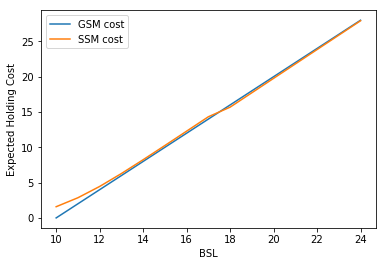

In [6]:
BSL_vec = np.arange(10, 25)
cost_GSM = []
cost_SSM = []
single_stage_SSM = GSM_to_SSM(single_stage)
for i in range(len(BSL_vec)):
    cost_GSM.append(solution_cost_from_base_stock_levels(single_stage, {1: BSL_vec[i]}))
    cost_SSM.append(expected_holding_cost(single_stage_SSM, {1: BSL_vec[i]}, x_num=100, d_num=50))
plt.plot(BSL_vec, cost_GSM, BSL_vec, cost_SSM)
plt.legend(['GSM cost', 'SSM cost'])
plt.xlabel('BSL')
plt.ylabel('Expected Holding Cost')

As expected, holding cost increases with BSL, and GSM and SSM costs agree except for small BSL values, when the number of stockouts would be non-negligible; in these cases, GSM-based holding cost is inaccurate because it assumes E[ending on-hand inventory] = E[BSL - mu], whereas really it = E[(BSL - mu)^+].

### Plot costs vs. k.

Text(0, 0.5, 'Cost')

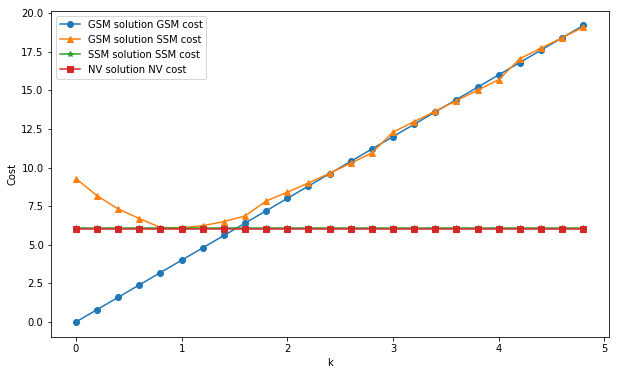

In [21]:
# Plot costs vs k.

# Array of k values to use.
k_vals = np.arange(0, 5, 0.2)

# Arrays of costs.
cost_GG = [] # GSM cost, GSM solution
cost_SG = [] # SSM cost, GSM solution
cost_SS = [] # SSM cost, SSM solution
cost_NV = [] # Newsvendor cost (just to double-check)

# Parameters (for convenience).
p = 10
h = single_stage.nodes[1]['holding_cost'] 
mu = single_stage.nodes[1]['external_demand_mean']
sigma = single_stage.nodes[1]['external_demand_standard_deviation']

# Convert GSM network to SSM network and add stockout cost.
single_stage_SSM = GSM_to_SSM(single_stage, p=p)

# Solve GSM for each k; get corresponding GSM and SSM costs.
for k_ind in range(len(k_vals)):
    # Solve GSM for this k.
    GSM_bsl, GSM_cost, SSM_cost = opt_wrt_k(k_vals[k_ind], single_stage)
    cost_GG.append(GSM_cost)
    cost_SG.append(SSM_cost)
    # Calculate optimal SSM solution and cost.
    S_star, C_star = optimize_base_stock_levels(single_stage_SSM, S=None, plots=False, x=None, x_num=100, d_num=50)
    cost_SS.append(C_star)
    # Calculate NV solution and cost (just to double-check).
    S_NV = stats.norm.ppf(p/(p+h), mu, sigma)
    C_NV = (h + p) * stats.norm.pdf(stats.norm.ppf(p/(p+h))) * sigma # (4.30) in Snyder and Shen (2019)
    cost_NV.append(C_NV)
    
plt.plot(k_vals, cost_GG, '-o',
         k_vals, cost_SG, '-^',
         k_vals, cost_SS, '-*',
         k_vals, cost_NV, '-s')
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend(['GSM solution GSM cost', 'GSM solution SSM cost', 'SSM solution SSM cost', 'NV solution NV cost'])
plt.xlabel('k')
plt.ylabel('Cost')

As expected:
    - GSM cost of GSM solution increases linearly with k
    - Actual (SSM) cost of GSM solution is convex wrt k
    - Actual (SSM) cost of GSM solution with k=k* coincides with SSM solution
    - SSM solution is flat wrt k (it doesn't depend on k)
    - NV solution matches SSM solution (they are equivalent)
    - (slight wiggles in SSM cost are due to discretization)

### Find optimal k.

In [34]:
# Find optimal k, compare to z_alpha.
k_star = optimize_k(single_stage, high=6)
z_alpha = stats.norm.ppf(p/(p+h))
print("k* = {}, z_alpha = {}, ratio = {}".format(k_star, z_alpha, k_star / z_alpha))

k* = 0.9722900390625, z_alpha = 0.967421566101701, ratio = 1.005032421367674


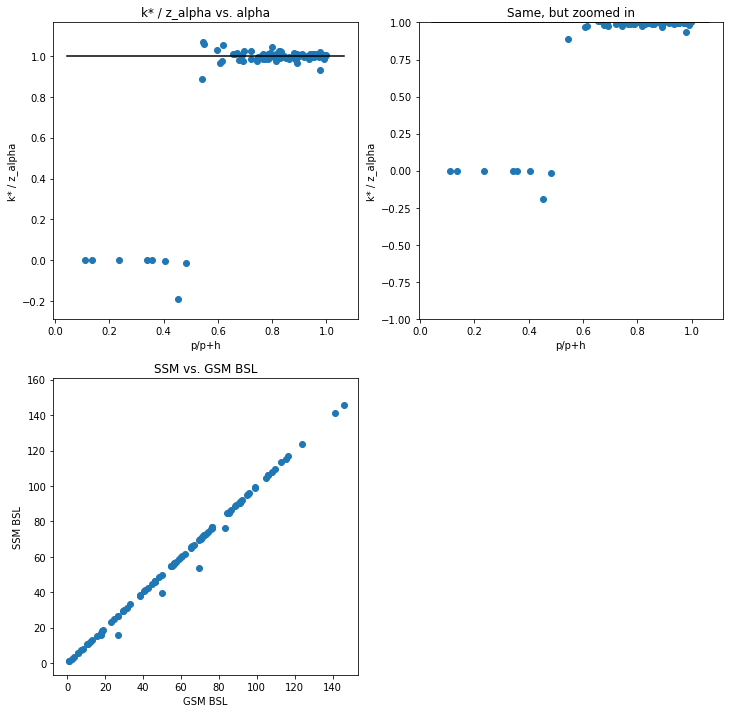

In [74]:
# Generate random data, calculate k* and z_alpha for each.
# NOTE: THIS WILL BE VERY SLOW!!
num_instances = 100
p = {}
h = {}
alpha = {}
z_alpha = {}
mu = {}
sigma = {}
k_star = {}
ratio = {}
GSM_bsl = {}
SSM_bsl = {}
for i in range(num_instances):
    # Generate random data.
    p[i] = np.random.rand() * 500
    h[i] = np.random.rand() * 100
    alpha[i] = p[i] / (p[i] + h[i])
    z_alpha[i] = stats.norm.ppf(alpha[i])
    mu[i] = np.random.rand() * 100
    sigma[i] = (mu[i] / 3) * np.random.rand()
    # Build GSM instance.
    new_single_stage = nx.DiGraph()
    new_single_stage.add_node(1, processing_time=1,
                     external_inbound_cst=0,
                     external_outbound_cst=0,
                     holding_cost=h[i],
                     stockout_cost=p[i], # ignored in GSM optimization
                     demand_bound_constant=1,
                     external_demand_mean=mu[i],
                     external_demand_standard_deviation=sigma[i])
    new_single_stage = preprocess_tree(new_single_stage)
    # Solve.
    k_star[i], temp_bsl = optimize_k(new_single_stage, high=6)
    GSM_bsl[i] = temp_bsl[1]
    SSM_bsl[i] = stats.norm.ppf(alpha[i], mu[i], sigma[i])
    ratio[i] = k_star[i] / z_alpha[i]

print('DONE!')

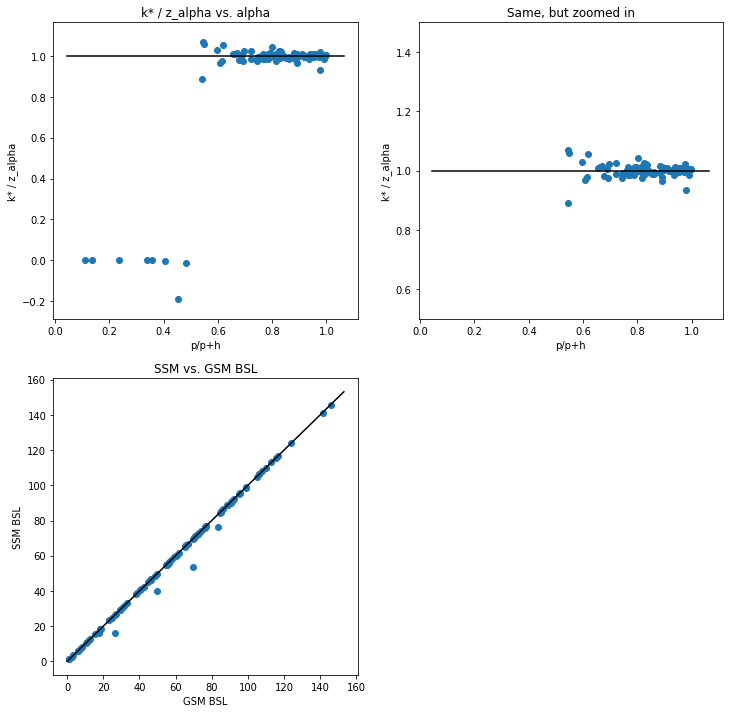

In [78]:
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(alpha.values(), ratio.values())
xmin, xmax = ax1.get_xbound()
ax1.plot([xmin,xmax], [1,1], 'k')
plt.xlabel('p/p+h')
plt.ylabel('k* / z_alpha')
plt.title('k* / z_alpha vs. alpha')

ax2 = plt.subplot(2, 2, 2)
ax2.scatter(alpha.values(), ratio.values())
xmin, xmax = ax2.get_xbound()
ax2.plot([xmin,xmax], [1,1], 'k')
plt.ylim(0.5, 1.5)
plt.xlabel('p/p+h')
plt.ylabel('k* / z_alpha')
plt.title('Same, but zoomed in')

ax3 = plt.subplot(2, 2, 3)
ax3.scatter(GSM_bsl.values(), SSM_bsl.values())
xmin, xmax = ax3.get_xbound()
ax3.plot([0,xmax], [0,xmax], 'k')
plt.xlabel('GSM BSL')
plt.ylabel('SSM BSL')
plt.title('SSM vs. GSM BSL')

fig = plt.gcf()
fig.set_size_inches(12, 12)

As expected, k* mostly equals z_alpha, and the GSM and SSM base-stock levels mostly agree with each other. There are some outliers which need further investigation -- might just be due to rounding/discretizing, might not.

## Two-stage network.
Build a two-stage network. Do some experiments.

In [106]:
# Create DiGraph.
two_stage = nx.DiGraph()
two_stage.add_node(1, processing_time=1,
                     external_inbound_cst=0,
                     external_outbound_cst=0,
                     holding_cost=2, # local
                     stockout_cost=10, # ignored in GSM optimization
                     demand_bound_constant=3,
                     external_demand_mean=10,
                     external_demand_standard_deviation=2)
two_stage.add_node(2, processing_time=1,
                     external_inbound_cst=0,
                     holding_cost=1, # local
                     demand_bound_constant=3)
two_stage.add_edge(2, 1)

# Preprocess.
two_stage = preprocess_tree(two_stage)

### Plot holding cost vs. BSL just to test.

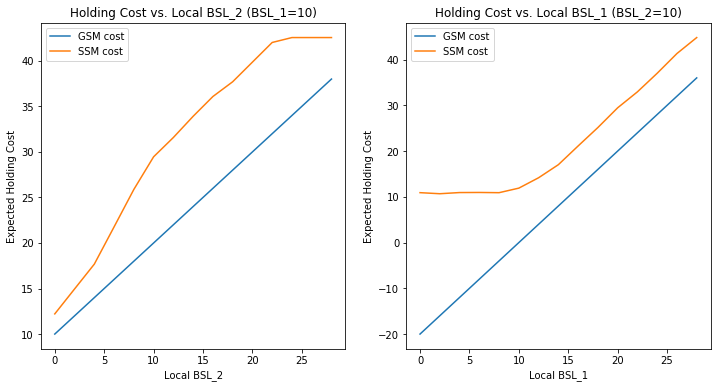

In [108]:
BSL_vec = np.arange(0, 30, 2)
two_stage_SSM = GSM_to_SSM(two_stage)

# Fix BSL_1 = 10, plot cost vs. BSL_2.
cost_GSM = []
cost_SSM = []
for i in range(len(BSL_vec)):
    local_S = {1: 20, 2: BSL_vec[i]}
    cost_GSM.append(solution_cost_from_base_stock_levels(two_stage, local_S))
    echelon_S = local_to_echelon_base_stock_levels(two_stage, local_S)
    cost_SSM.append(expected_holding_cost(two_stage_SSM, echelon_S, x_num=100, d_num=50))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(BSL_vec, cost_GSM, BSL_vec, cost_SSM)
plt.legend(['GSM cost', 'SSM cost'])
plt.title('Holding Cost vs. Local BSL_2 (BSL_1=10)')
plt.xlabel('Local BSL_2');
plt.ylabel('Expected Holding Cost');

# Fix BSL_2 = 10, plot cost vs. BSL_1.
cost_GSM = []
cost_SSM = []
for i in range(len(BSL_vec)):
    local_S = {1: BSL_vec[i], 2: 10}
    cost_GSM.append(solution_cost_from_base_stock_levels(two_stage, local_S))
    echelon_S = local_to_echelon_base_stock_levels(two_stage, local_S)
    cost_SSM.append(expected_holding_cost(two_stage_SSM, echelon_S, x_num=100, d_num=50))
ax2 = plt.subplot(1, 2, 2)
ax2.plot(BSL_vec, cost_GSM, BSL_vec, cost_SSM)
plt.legend(['GSM cost', 'SSM cost'])
plt.title('Holding Cost vs. Local BSL_1 (BSL_2=10)')
plt.xlabel('Local BSL_1');
plt.ylabel('Expected Holding Cost');

fig = plt.gcf()
fig.set_size_inches(12, 6)

As expected, holding cost increases with BSL, and GSM and SSM costs agree except for small BSL values, when the number of stockouts would be non-negligible; in these cases, GSM-based holding cost is inaccurate because it assumes E[ending on-hand inventory] = E[BSL - mu], whereas really it = E[(BSL - mu)^+].